<a href="https://colab.research.google.com/github/Al95200/machine-translation/blob/master/traducteur_anglais_francais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
# # function to read raw text file
# def read_text(filename):
#         # open the file
#         file = open(filename, mode = 'rt',encoding='utf-8')
        
#         # read all text
#         text = file.read()
#         file.close()
#         return text

In [3]:
# # split a text into sentences
# def to_lines(text):
#       sents = text.strip().split('\n')
#       sents = [i.split('\t') for i in sents]
#       return sents

In [4]:
with open("small_vocab_fr.txt") as f1, open("small_vocab_en.txt") as f2:
       line_file1 = f1.readlines()
       line_file2 = f2.readlines()
       print(len(line_file1), len(line_file2))

137860 137860


In [5]:
temp = []
fr_eng = []
for fr, en in zip(line_file1, line_file2):
    temp.append(en)
    temp.append(fr)
    fr_eng.append(temp)
    temp = []

In [6]:
fr_eng = array(fr_eng)
# fr_eng = fr_eng[:50000,:]

In [7]:
fr_eng

array([['new jersey is sometimes quiet during autumn , and it is snowy in april .\n',
        "new jersey est parfois calme pendant l' automne , et il est neigeux en avril .\n"],
       ['the united states is usually chilly during july , and it is usually freezing in november .\n',
        'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .\n'],
       ['california is usually quiet during march , and it is usually hot in june .\n',
        'california est généralement calme en mars , et il est généralement chaud en juin .\n'],
       ...,
       ['india is never wet during summer , but it is sometimes chilly in winter .\n',
        "l' inde est jamais mouillé pendant l' été , mais il est parfois froid en hiver .\n"],
       ['france is never chilly during january , but it is never mild in october .\n',
        'la france est jamais froid en janvier , mais il est jamais doux en octobre .\n'],
       ['the orange is her favorite fruit , but the ban

In [8]:
# Remove punctuation
fr_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,0]]
fr_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,1]]

fr_eng

array([['new jersey is sometimes quiet during autumn  and it is snowy in april \n',
        'new jersey est parfois calme pendant l automne  et il est neigeux en avril \n'],
       ['the united states is usually chilly during july  and it is usually freezing in november \n',
        'les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre \n'],
       ['california is usually quiet during march  and it is usually hot in june \n',
        'california est généralement calme en mars  et il est généralement chaud en juin \n'],
       ...,
       ['india is never wet during summer  but it is sometimes chilly in winter \n',
        'l inde est jamais mouillé pendant l été  mais il est parfois froid en hiver \n'],
       ['france is never chilly during january  but it is never mild in october \n',
        'la france est jamais froid en janvier  mais il est jamais doux en octobre \n'],
       ['the orange is her favorite fruit  but the banana is your favorite \n',

In [9]:
# convert text to lowercase
for i in range(len(fr_eng)):
    fr_eng[i,0] = fr_eng[i,0].lower()
    fr_eng[i,1] = fr_eng[i,1].lower()

fr_eng

array([['new jersey is sometimes quiet during autumn  and it is snowy in april \n',
        'new jersey est parfois calme pendant l automne  et il est neigeux en avril \n'],
       ['the united states is usually chilly during july  and it is usually freezing in november \n',
        'les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre \n'],
       ['california is usually quiet during march  and it is usually hot in june \n',
        'california est généralement calme en mars  et il est généralement chaud en juin \n'],
       ...,
       ['india is never wet during summer  but it is sometimes chilly in winter \n',
        'l inde est jamais mouillé pendant l été  mais il est parfois froid en hiver \n'],
       ['france is never chilly during january  but it is never mild in october \n',
        'la france est jamais froid en janvier  mais il est jamais doux en octobre \n'],
       ['the orange is her favorite fruit  but the banana is your favorite \n',

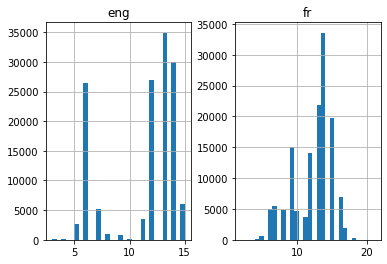

In [10]:
# empty lists
eng_l = []
fr_l = []

# populate the lists with sentence lengths
for i in fr_eng[:,0]:
      eng_l.append(len(i.split()))

for i in fr_eng[:,1]:
      fr_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'fr':fr_l})

length_df.hist(bins = 30)
plt.show()

In [11]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [12]:
# prepare English tokenizer
eng_tokenizer = tokenization(fr_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 20
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 200


In [13]:
# prepare French tokenizer
fr_tokenizer = tokenization(fr_eng[:, 1])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

fr_length = 20
print('French Vocabulary Size: %d' % fr_vocab_size)

French Vocabulary Size: 345


In [14]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [15]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(fr_eng, test_size=0.2, random_state = 12)

In [16]:
# prepare training data
trainX = encode_sequences(fr_tokenizer, fr_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fr_tokenizer, fr_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [17]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [18]:
# model compilation
model = define_model(fr_vocab_size, eng_vocab_size, fr_length, eng_length, 512)

In [19]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [20]:
filename = 'model.h1.15_07_2020'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 88230 samples, validate on 22058 samples
Epoch 1/30
88230/88230 [==============================] - 22s 250us/step - loss: 2.0961 - val_loss: 1.3472

Epoch 00001: val_loss improved from inf to 1.34716, saving model to model.h1.15_07_2020
Epoch 2/30
88230/88230 [==============================] - 20s 224us/step - loss: 1.1178 - val_loss: 0.7583

Epoch 00002: val_loss improved from 1.34716 to 0.75829, saving model to model.h1.15_07_2020
Epoch 3/30
88230/88230 [==============================] - 20s 223us/step - loss: 0.7429 - val_loss: 0.5764

Epoch 00003: val_loss improved from 0.75829 to 0.57641, saving model to model.h1.15_07_2020
Epoch 4/30
88230/88230 [==============================] - 20s 224us/step - loss: 0.5793 - val_loss: 0.4842

Epoch 00004: val_loss improved from 0.57641 to 0.48424, saving model to model.h1.15_07_2020
Epoch 5/30
88230/88230 [==============================] - 20s 222us/step - loss: 0.4565 - val_loss: 0.3603

Epoch 00005: val_loss improved from 0.48424 to

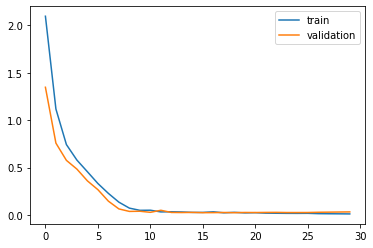

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [22]:
model = load_model('model.h1.15_07_2020')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [23]:
preds

array([[ 29,  11,  13, ...,   0,   0,   0],
       [ 24,   1,  10, ...,   0,   0,   0],
       [  5,  86,   1, ...,   0,   0,   0],
       ...,
       [151, 145,  81, ...,   0,   0,   0],
       [ 19,   1,  66, ...,   0,   0,   0],
       [  5,  85,   1, ...,   0,   0,   0]])

In [24]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [25]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [26]:
preds_text

['your favorite fruit is the apple but their favorite is the orange        ',
 'france is never rainy during august and it is sometimes relaxing in winter       ',
 'the lime is her favorite fruit but the apple is our favorite        ',
 'he likes a big black automobile              ',
 'california is busy during july and it is sometimes beautiful in december        ',
 'new jersey is usually hot during march but it is nice in december       ',
 'they might go to paris next february             ',
 'our most loved fruit is the orange but her most loved is the lime      ',
 'he likes oranges mangoes and limes              ',
 'india is usually mild during fall but it is usually chilly in september       ',
 'california is chilly during september but it is never hot in may        ',
 'california is sometimes busy during fall and it is relaxing in july        ',
 'he drove the old blue automobile              ',
 'her most feared animals were lions              ',
 'india is sometimes rel

In [33]:
pred_df = pd.DataFrame({'predicted' : preds_text, 'actual' : test[:,0]})

In [34]:
# print some rows randomly
pred_df.sample(50)

,predicted,actual
15880,california is never busy during fall and it is usually nice in may,california is never busy during fall and it is usually pleasant in may \n
17972,the orange is my most loved fruit but the grape is your most loved,the orange is my most loved fruit but the grape is your most loved \n
24585,he likes peaches grapefruit and strawberries,he likes peaches grapefruit and strawberries \n
5729,my favorite fruit is the pear but her favorite is the lemon,my favorite fruit is the pear but her favorite is the lemon \n
12862,the grape is your least favorite fruit but the lemon is my least favorite,the grape is your least favorite fruit but the lemon is my least favorite \n
12664,she was driving that old black car,she was driving that old black automobile \n
23511,india is usually beautiful during may but it is never quiet in september,india is usually beautiful during may but it is never quiet in september \n
18470,our least favorite fruit is the orange but their least favorite is the apple,our least favorite fruit is the orange but their least favorite is the apple \n
8999,paris is usually rainy during winter but it is usually busy in summer,paris is usually rainy during winter but it is usually busy in summer \n
4230,paris is sometimes relaxing during summer but it is rainy in march,paris is sometimes relaxing during summer but it is rainy in march \n


In [29]:
def Average(lst): 
    return sum(lst) / len(lst)
pred_df

,predicted,actual
0,your favorite fruit is the apple but their favorite is the orange,your favorite fruit is the apple but their favorite is the orange \n
1,france is never rainy during august and it is sometimes relaxing in winter,france is never rainy during august and it is sometimes relaxing in winter \n
2,the lime is her favorite fruit but the apple is our favorite,the lime is her favorite fruit but the apple is our favorite \n
3,he likes a big black automobile,he likes a big black automobile \n
4,california is busy during july and it is sometimes beautiful in december,california is busy during july and it is sometimes beautiful in december \n
...,...,...
27567,her least favorite fruit is the peach but my least favorite is the banana,his least favorite fruit is the peach but my least favorite is the banana \n
27568,the pear is her favorite fruit but the grapefruit is her favorite,the pear is his favorite fruit but the grapefruit is her favorite \n
27569,its difficult to translate french to spanish,its difficult to translate french to spanish \n
27570,india is relaxing during autumn but it is chilly in spring,india is relaxing during fall but it is chilly in spring \n
